### IMPORT LIBRERIE

In [2]:
# --- 1. IMPORT LIBRERIE ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pd.set_option('display.max_columns', None)
print("Librerie importate con successo.")

Librerie importate con successo.


### CARICAMENTO E ISPEZIONE DATI

In [3]:
# --- 2. CARICAMENTO DATI ---

file_path = '../data/puliti/movimento_fe.csv'
try:
    df = pd.read_csv(file_path)
    df_ml = df.copy()
    print(f"File '{file_path}' caricato con successo.")
    print(f"Dimensioni: {df_ml.shape[0]} righe, {df_ml.shape[1]} colonne.")
    display(df_ml.head())
except FileNotFoundError:
    print(f"ERRORE: File '{file_path}' non trovato.")

File '../data/puliti/movimento_fe.csv' caricato con successo.
Dimensioni: 15738 righe, 62 colonne.


,Name,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,Positioning,Finishing,Shot Power,Long Shots,Volleys,Penalties,Vision,Crossing,Free Kick Accuracy,Short Passing,Long Passing,Curve,Dribbling,Agility,Balance,Reactions,Ball Control,Composure,Interceptions,Heading Accuracy,Def Awareness,Standing Tackle,Sliding Tackle,Jumping,Stamina,Strength,Aggression,Position,Weak foot,Skill moves,Preferred foot,Height,Weight,Alternative positions,Age,Nation,League,Team,play style,num_alt_pos_att,num_alt_pos_cen,num_alt_pos_dif,ps_scoring,ps_scoring_plus,ps_passing,ps_passing_plus,ps_control,ps_control_plus,ps_defend,ps_defend_plus,ps_physical,ps_physical_plus
0,Kylian Mbappé,91,97,90,80,92,36,78,97,97,93,94,90,83,84,84,83,78,69,86,71,80,93,93,82,93,92,88,38,73,26,34,32,88,88,77,64,ST,4,5,Right,"182cm / 6'0""",75kg / 165lb,LW,25,France,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Acrobatic, Finesse Shot, Flair, R...",1,0,0,1,0,0,0,1,0,0,0,2,1
1,Rodri,91,66,80,86,84,87,85,65,66,76,74,92,89,71,62,84,76,64,93,91,86,84,66,67,93,90,94,84,81,92,87,82,83,91,83,85,CDM,4,3,Right,"191cm / 6'3""",82kg / 181lb,CM,28,Spain,Premier League,Manchester City,"Tiki Taka+, Aerial, Bruiser, Long Ball Pass, P...",0,1,0,1,0,1,1,1,0,1,0,1,0
2,Erling Haaland,91,88,92,70,81,45,88,80,94,96,96,94,83,90,90,74,58,62,77,66,77,79,77,69,94,83,87,43,83,38,47,29,92,76,93,88,ST,3,3,Left,"195cm / 6'5""",94kg / 207lb,NaN,24,Norway,Premier League,Manchester City,"Acrobatic+, Bruiser, Power Header, Power Shot,...",0,0,0,2,0,0,0,1,0,1,0,0,1
3,Jude Bellingham,90,80,87,83,88,78,83,81,80,91,90,85,86,77,74,90,66,68,89,89,73,89,82,79,91,89,87,82,75,77,79,77,84,93,77,85,CAM,4,4,Right,"186cm / 6'1""",75kg / 165lb,CM,21,England,LALIGA EA SPORTS,Real Madrid,"Relentless+, Flair, Intercept, Slide Tackle, T...",0,1,0,0,0,0,0,2,0,2,0,0,1
4,Vini Jr.,90,95,84,81,91,29,69,95,95,87,89,81,83,73,71,85,81,62,83,77,79,93,94,84,86,90,83,26,50,32,25,18,74,84,65,58,LW,4,5,Right,"176cm / 5'9""",73kg / 161lb,"ST, LM",24,Brazil,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Chip Shot, Finesse Shot, First To...",1,1,0,2,0,0,0,2,0,0,0,1,1


### CREAZIONE VARIABILE TARGET (Y)

In [4]:
# --- 3. CREAZIONE VARIABILE TARGET (y) ---
print("Creazione colonna Target 'is_left_footed'...")

# Usiamo il nome 'Preferred foot' che abbiamo trovato con la cella di debug
try:
    # 1 = Sinistro, 0 = Destro
    df_ml['is_left_footed'] = (df_ml['Preferred foot'] == 'Left').astype(int)
    print("Colonna Target 'is_left_footed' creata.")
    # Verifica
    display(df_ml[['Name', 'Preferred foot', 'is_left_footed']].head())
except KeyError:
    print("ERRORE: Colonna 'Preferred foot' non trovata. Controlla l'ortografia.")

Creazione colonna Target 'is_left_footed'...
Colonna Target 'is_left_footed' creata.


,Name,Preferred foot,is_left_footed
0,Kylian Mbappé,Right,0
1,Rodri,Right,0
2,Erling Haaland,Left,1
3,Jude Bellingham,Right,0
4,Vini Jr.,Right,0


### ENCODING FINALE DELLE FEATURES (X)

In [5]:
# --- 4. ENCODING FEATURES (X) ---
print("Inizio encoding features...")

# 'Work rates' (Codice difensivo, verrà saltato)
if 'Work rates' in df_ml.columns:
    try:
        wr_split = df_ml['Work rates'].str.split('/ ', expand=True)
        work_rate_map = {'Low': 0, 'Medium': 1, 'High': 2}
        df_ml['WR_Attack_num'] = wr_split[0].map(work_rate_map).fillna(1).astype(int)
        df_ml['WR_Defense_num'] = wr_split[1].map(work_rate_map).fillna(1).astype(int)
        print("Create 'WR_Attack_num' e 'WR_Defense_num'.")
    except Exception as e:
        print(f"Warning: Impossibile processare 'Work rates'. Errore: {e}")
else:
    print("Colonna 'Work rates' non trovata, encoding saltato (come previsto).")

print("Encoding features completato.")

Inizio encoding features...
Colonna 'Work rates' non trovata, encoding saltato (come previsto).
Encoding features completato.


### PULIZIA FINALE

In [6]:
# --- 5. PULIZIA FINALE (DROP COLONNE NON NUMERICHE) ---

print("Inizio pulizia finale colonne...")

colonne_da_rimuovere = [
    # Testo originale che abbiamo usato (o scartato)
    'Preferred foot',       # LA STRINGA (il target numerico 'is_left_footed' rimane)
    'Alternative positions',
    'Height',
    'Weight',
    
    # Altro testo inutile per questo task
    'Position',
    'play style',
    'Work rates',           # Rimuoviamo anche se non c'è, per sicurezza
    
    # Identificatori
    'Name', 
    'Known As',
    'Player ID',
    'Full Name',
    'Age',
    'Nation',
    'League',
    'Team'
]

colonne_esist_da_rimuovere = [col for col in colonne_da_rimuovere if col in df_ml.columns]
print(f"Rimozione delle seguenti colonne: {colonne_esist_da_rimuovere}")

df_ml = df_ml.drop(columns=colonne_esist_da_rimuovere)
print("Pulizia completata.")

Inizio pulizia finale colonne...
Rimozione delle seguenti colonne: ['Preferred foot', 'Alternative positions', 'Height', 'Weight', 'Position', 'play style', 'Name', 'Age', 'Nation', 'League', 'Team']
Pulizia completata.


### VERIFICA FINALE

In [7]:
# --- 6. VERIFICA FINALE (SANITY CHECK) ---
print("Controllo finale dei tipi di dato (dtypes) e valori nulli:")
df_ml.info()

print("\nHead del DataFrame finale pronto per il ML:")
display(df_ml.head())

Controllo finale dei tipi di dato (dtypes) e valori nulli:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   OVR                 15738 non-null  int64
 1   PAC                 15738 non-null  int64
 2   SHO                 15738 non-null  int64
 3   PAS                 15738 non-null  int64
 4   DRI                 15738 non-null  int64
 5   DEF                 15738 non-null  int64
 6   PHY                 15738 non-null  int64
 7   Acceleration        15738 non-null  int64
 8   Sprint Speed        15738 non-null  int64
 9   Positioning         15738 non-null  int64
 10  Finishing           15738 non-null  int64
 11  Shot Power          15738 non-null  int64
 12  Long Shots          15738 non-null  int64
 13  Volleys             15738 non-null  int64
 14  Penalties           15738 non-null  int64
 15  Vision              15738 no

,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,Positioning,Finishing,Shot Power,Long Shots,Volleys,Penalties,Vision,Crossing,Free Kick Accuracy,Short Passing,Long Passing,Curve,Dribbling,Agility,Balance,Reactions,Ball Control,Composure,Interceptions,Heading Accuracy,Def Awareness,Standing Tackle,Sliding Tackle,Jumping,Stamina,Strength,Aggression,Weak foot,Skill moves,num_alt_pos_att,num_alt_pos_cen,num_alt_pos_dif,ps_scoring,ps_scoring_plus,ps_passing,ps_passing_plus,ps_control,ps_control_plus,ps_defend,ps_defend_plus,ps_physical,ps_physical_plus,is_left_footed
0,91,97,90,80,92,36,78,97,97,93,94,90,83,84,84,83,78,69,86,71,80,93,93,82,93,92,88,38,73,26,34,32,88,88,77,64,4,5,1,0,0,1,0,0,0,1,0,0,0,2,1,0
1,91,66,80,86,84,87,85,65,66,76,74,92,89,71,62,84,76,64,93,91,86,84,66,67,93,90,94,84,81,92,87,82,83,91,83,85,4,3,0,1,0,1,0,1,1,1,0,1,0,1,0,0
2,91,88,92,70,81,45,88,80,94,96,96,94,83,90,90,74,58,62,77,66,77,79,77,69,94,83,87,43,83,38,47,29,92,76,93,88,3,3,0,0,0,2,0,0,0,1,0,1,0,0,1,1
3,90,80,87,83,88,78,83,81,80,91,90,85,86,77,74,90,66,68,89,89,73,89,82,79,91,89,87,82,75,77,79,77,84,93,77,85,4,4,0,1,0,0,0,0,0,2,0,2,0,0,1,0
4,90,95,84,81,91,29,69,95,95,87,89,81,83,73,71,85,81,62,83,77,79,93,94,84,86,90,83,26,50,32,25,18,74,84,65,58,4,5,1,1,0,2,0,0,0,2,0,0,0,1,1,0


### Definizione di X (Features) e y (Target)

In [8]:
# --- 7. DEFINIZIONE X (FEATURES) e y (TARGET) ---

TASK_TARGET = 'is_left_footed' 
print(f"TASK: Predire '{TASK_TARGET}'\n")

# 1. Definiamo il Target (y) - La nostra risposta (0 o 1)
y = df_ml[TASK_TARGET]

# 2. Definiamo le Features (X) - I nostri indizi
#    X è tutto il dataframe MENO la colonna target
X = df_ml.drop(columns=[TASK_TARGET])

# --- Verifica ---
print(f"Forma delle Features (X): {X.shape}")
print(f"Forma del Target (y): {y.shape}")
print("\nDistribuzione del Target (y):")
display(y.value_counts(normalize=True) * 100) # Vediamo quanti sono mancini

TASK: Predire 'is_left_footed'

Forma delle Features (X): (15738, 51)
Forma del Target (y): (15738,)

Distribuzione del Target (y):


is_left_footed
0    75.123904
1    24.876096
Name: proportion, dtype: float64

### SPLIT DATI

In [9]:
# --- 8. TRAIN-TEST SPLIT (con Stratificazione) ---

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y) # Importantissimo!

print(f"Dimensioni X_train: {X_train.shape}")
print(f"Dimensioni X_test: {X_test.shape}")

Dimensioni X_train: (11016, 51)
Dimensioni X_test: (4722, 51)


### SCALING FEATURES

In [10]:
# --- 9. SCALING DELLE FEATURES ---
print("Inizio scaling delle features...")
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaling completato.")

### il signor ticchia ha detto che lo standard scaler non va bene

Inizio scaling delle features...
Scaling completato.


### ADDESTRAMENTO MODELLO (LOGISTIC REGRESSION)

In [11]:
# --- 10. ADDESTRAMENTO MODELLO (LOGISTIC REGRESSION) ---
print("Inizio addestramento LogisticRegression...")

model_lr_piede = LogisticRegression(max_iter=1000, random_state=42)
model_lr_piede.fit(X_train_scaled, y_train)

print("... Addestramento completato!")

Inizio addestramento LogisticRegression...
... Addestramento completato!


### VALUTAZIONE MODELLO

Inizio valutazione sul Test Set...

Accuratezza (Logistic Regression): 76.34%

--- Obiettivo Investigativo ---
RISULTATO: POSITIVO! L'accuratezza è > 50%.
Sembra esistere un pattern statistico per i mancini!

--- Classification Report ---
              precision    recall  f1-score   support

  Destro (0)       0.77      0.98      0.86      3547
Sinistro (1)       0.63      0.12      0.20      1175

    accuracy                           0.76      4722
   macro avg       0.70      0.55      0.53      4722
weighted avg       0.74      0.76      0.70      4722


--- Matrice di Confusione ---


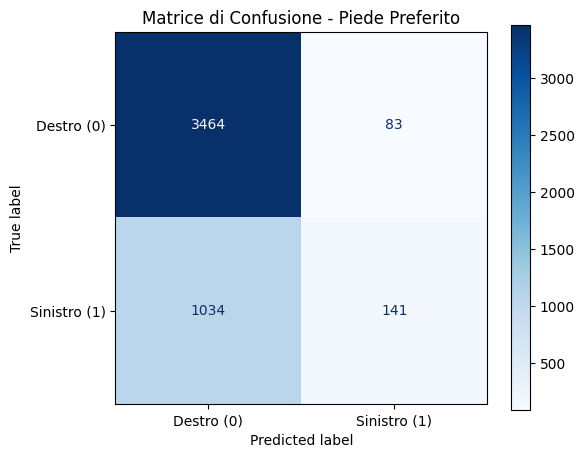

In [12]:
# --- 11. VALUTAZIONE MODELLO SUL TEST SET ---

print("Inizio valutazione sul Test Set...")
y_pred_lr_piede = model_lr_piede.predict(X_test_scaled)

# 1. Calcoliamo l'accuratezza
accuracy_lr_piede = accuracy_score(y_test, y_pred_lr_piede)
print(f"\nAccuratezza (Logistic Regression): {accuracy_lr_piede * 100:.2f}%")

print("\n--- Obiettivo Investigativo ---")
if accuracy_lr_piede > 0.55: # Diamo un margine (55% invece di 50%)
    print("RISULTATO: POSITIVO! L'accuratezza è > 50%.")
    print("Sembra esistere un pattern statistico per i mancini!")
else:
    print("RISULTATO: NEGATIVO. L'accuratezza è vicina al 50%.")
    print("Il modello sta tirando a indovinare (nessun pattern trovato).")

# 2. Stampiamo il Classification Report
print("\n--- Classification Report ---")
# Qui 0 = Destro, 1 = Sinistro
print(classification_report(y_test, y_pred_lr_piede, target_names=['Destro (0)', 'Sinistro (1)']))

# 3. Creiamo la Matrice di Confusione
print("\n--- Matrice di Confusione ---")
# 
cm = confusion_matrix(y_test, y_pred_lr_piede, labels=model_lr_piede.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=['Destro (0)', 'Sinistro (1)'])
disp.plot(cmap='Blues', ax=ax, xticks_rotation='horizontal')
plt.title("Matrice di Confusione - Piede Preferito")
plt.show()

### BILANCIAMENTO

In [13]:
# --- 12. ADDESTRAMENTO MODELLO (Logistic Regression BILANCIATA) ---
print("Inizio addestramento LogisticRegression (con class_weight='balanced')...")

# class_weight='balanced' è la magia per i dati sbilanciati
model_lr_piede = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced' # <-- ECCO LA MODIFICA
)

model_lr_piede.fit(X_train_scaled, y_train)

print("... Addestramento completato!")

Inizio addestramento LogisticRegression (con class_weight='balanced')...
... Addestramento completato!


Inizio valutazione sul Test Set (con modello bilanciato)...

Accuratezza (Logistic Regression Bilanciata): 65.18%

--- Classification Report (Bilanciato) ---
              precision    recall  f1-score   support

  Destro (0)       0.85      0.65      0.74      3547
Sinistro (1)       0.38      0.66      0.48      1175

    accuracy                           0.65      4722
   macro avg       0.62      0.65      0.61      4722
weighted avg       0.73      0.65      0.67      4722


--- Obiettivo Investigativo (Bilanciato) ---
RISULTATO: POSITIVO! La Recall per i Sinistri è 0.66.
Il modello bilanciato sta trovando attivamente i mancini!

--- Matrice di Confusione (Bilanciata) ---


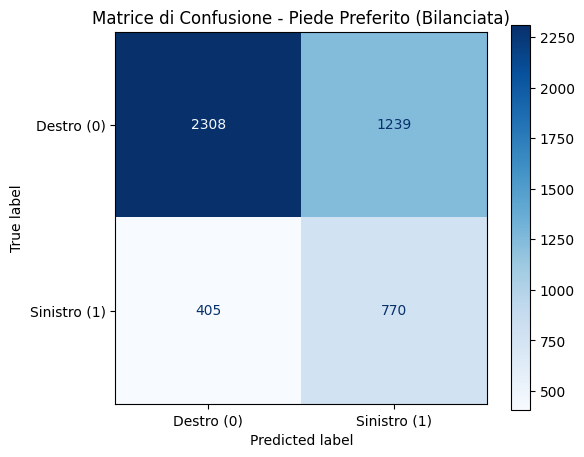

In [14]:
# --- 13. VALUTAZIONE MODELLO SUL TEST SET (BILANCIATO) ---

print("Inizio valutazione sul Test Set (con modello bilanciato)...")

# Facciamo le predizioni con il modello bilanciato
y_pred_lr_piede = model_lr_piede.predict(X_test_scaled)

# 1. Calcoliamo l'accuratezza
accuracy_lr_piede = accuracy_score(y_test, y_pred_lr_piede)
print(f"\nAccuratezza (Logistic Regression Bilanciata): {accuracy_lr_piede * 100:.2f}%")

# 2. Stampiamo il Classification Report
print("\n--- Classification Report (Bilanciato) ---")
# Qui 0 = Destro, 1 = Sinistro
report_bilanciato = classification_report(y_test, y_pred_lr_piede, 
                                          target_names=['Destro (0)', 'Sinistro (1)'],
                                          output_dict=True) # Salva come dizionario

print(classification_report(y_test, y_pred_lr_piede, 
                            target_names=['Destro (0)', 'Sinistro (1)']))


# --- Obiettivo Investigativo (usando il report appena creato) ---
f1_sinistro = report_bilanciato['Sinistro (1)']['f1-score']
recall_sinistro = report_bilanciato['Sinistro (1)']['recall']

print("\n--- Obiettivo Investigativo (Bilanciato) ---")
if recall_sinistro > 0.4: # Ora guardiamo la RECALL!
    print(f"RISULTATO: POSITIVO! La Recall per i Sinistri è {recall_sinistro:.2f}.")
    print("Il modello bilanciato sta trovando attivamente i mancini!")
else:
    print(f"RISULTATO: NEGATIVO. La Recall per i Sinistri è {recall_sinistro:.2f}.")
    print("Il modello fatica a trovare un pattern anche se bilanciato.")


# 3. Creiamo la Matrice di Confusione
print("\n--- Matrice di Confusione (Bilanciata) ---")
# 
cm = confusion_matrix(y_test, y_pred_lr_piede, labels=model_lr_piede.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=['Destro (0)', 'Sinistro (1)'])
disp.plot(cmap='Blues', ax=ax, xticks_rotation='horizontal')
plt.title("Matrice di Confusione - Piede Preferito (Bilanciata)")
plt.show()

---
### Esperimento 2: Random Forest (Bilanciato)
---

**Obiettivo:** Vedere se un modello più complesso (Random Forest) può migliorare la capacità di identificare i mancini (la Recall) rispetto alla Logistic Regression.

* **Modello LR (vecchio):** Accuracy 65.18%, Recall (Sinistro) 0.66
* **Modello RF (nuovo):** ???

Useremo `class_weight='balanced'` anche qui per un confronto onesto.

In [15]:
# --- 13. ADDESTRAMENTO MODELLO (RANDOM FOREST) ---

print("Inizio addestramento del modello Random Forest...")

model_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Addestriamo il modello su dati non scalati

model_rf.fit(X_train, y_train)

print("Modello Random Forest addestrato con successo.")

Inizio addestramento del modello Random Forest...
Modello Random Forest addestrato con successo.


Inizio valutazione del modello Random Forest...

Accuracy del modello Random Forest: 76.07%

 Accuracy logistic regression:  65,18%

--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

  Destro (0)       0.77      0.98      0.86      3547
Sinistro (1)       0.63      0.09      0.16      1175

    accuracy                           0.76      4722
   macro avg       0.70      0.54      0.51      4722
weighted avg       0.73      0.76      0.69      4722


 --- Confronto recall sinistri ---
Recall Logistic Regression: 0.66
Recall Random Forest: 0.09
La Logistic Regression ha una recall migliore per i mancini.

--- Matrice di Confusione (Random Forest) ---


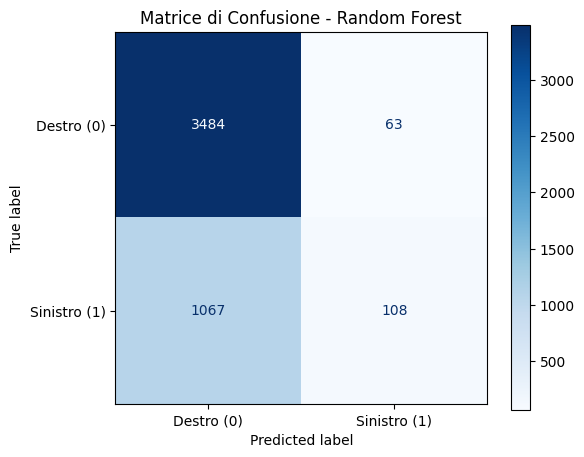

In [16]:
# --- 14. VALUTAZIONE DEL MODELLO RANDOM FOREST ---

print("Inizio valutazione del modello Random Forest...")

# Previsioni
y_pred_rf = model_rf.predict(X_test)

# Calcoliamo l'accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy del modello Random Forest: {acc_rf * 100:.2f}%")
print(f"\n Accuracy logistic regression:  65,18%")

# Classification Report
print("\n--- Classification Report (Random Forest) ---")
report_rf = classification_report(y_test, y_pred_rf,
                                 target_names=['Destro (0)', 'Sinistro (1)'],
                                 output_dict=True) # Salva come dizionario
print(classification_report(y_test, y_pred_rf,
                            target_names=['Destro (0)', 'Sinistro (1)']))

recall_lr = 0.66 
recall_rf = report_rf['Sinistro (1)']['recall']

print("\n --- Confronto recall sinistri ---")
print(f"Recall Logistic Regression: {recall_lr:.2f}")
print(f"Recall Random Forest: {recall_rf:.2f}")
if recall_rf > recall_lr:
    print("Il modello Random Forest ha una recall migliore per i mancini.")
else:
    print("La Logistic Regression ha una recall migliore per i mancini.")

# Matrice di Confusione
print("\n--- Matrice di Confusione (Random Forest) ---")
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=model_rf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, 
                            display_labels=['Destro (0)', 'Sinistro (1)'])
disp_rf.plot(cmap='Blues', ax=ax, xticks_rotation='horizontal')
plt.title("Matrice di Confusione - Random Forest")
plt.show()

---
### Esperimento 3: Support Vector Machine (SVC)
---

**Obiettivo:** Vedere se un modello basato sui "margini" (SVM) può battere la Logistic Regression nell'identificare i mancini.

* **Modello LR (campione):** Accuracy 65.18%, Recall (Sinistro) 0.66
* **Modello RF (fallito):** Accuracy 76.07%, Recall (Sinistro) 0.09
* **Modello SVM (sfidante):** ???

In [17]:
# --- 17. ADDESTRAMENTO MODELLO (SVM BILANCIATO) ---

print("Inizio addestramento del modello SVM bilanciato...")

# Inizializziamo il modello SVM con class_weight='balanced'
model_svm = SVC(
    kernel='rbf',
    class_weight='balanced',
    random_state=42
)

model_svm.fit(X_train_scaled, y_train)

print("Modello SVM addestrato con successo.")

Inizio addestramento del modello SVM bilanciato...
Modello SVM addestrato con successo.


Inizio valutazione del modello SVM...

Accuracy SVM bilanciata: 68.61%

 Accuracy logistic regression bilanciata:  65,18%

--- Classification Report (SVM Bilanciato) ---
              precision    recall  f1-score   support

  Destro (0)       0.85      0.71      0.77      3547
Sinistro (1)       0.41      0.61      0.49      1175

    accuracy                           0.69      4722
   macro avg       0.63      0.66      0.63      4722
weighted avg       0.74      0.69      0.70      4722


 --- Confronto recall sinistri ---
Recall Logistic Regression: 0.66
Recall Random Forest: 0.09
Recall SVM: 0.61
La Logistic Regression ha la recall migliore per i mancini.

--- Matrice di Confusione (SVM Bilanciato) ---


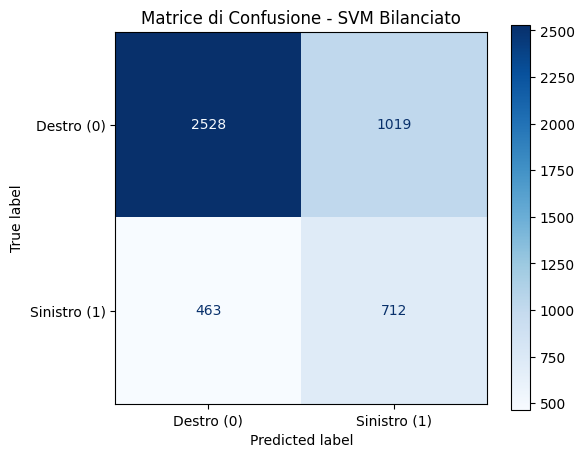

In [19]:
# --- 18. VALUTAZIONE DEL MODELLO SVM ---

print("Inizio valutazione del modello SVM...")

# Facciamo le predizioni sui dati di test scalati
y_pred_svm = model_svm.predict(X_test_scaled)

# Calcoliamo l'accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nAccuracy SVM bilanciata: {acc_svm * 100:.2f}%")
print(f"\n Accuracy logistic regression bilanciata:  65,18%")   #RICONTROLLARE IL VALORE

# Classification Report
print("\n--- Classification Report (SVM Bilanciato) ---")
report_svm = classification_report(y_test, y_pred_svm,
                                    target_names=['Destro (0)', 'Sinistro (1)'],
                                    output_dict=True) # Salva come dizionario
print(classification_report(y_test, y_pred_svm,
                            target_names=['Destro (0)', 'Sinistro (1)']))

# Confronto recall
recall_svm = report_svm['Sinistro (1)']['recall']
recall_lr = 0.66
recall_rf = 0.09    # RICONTROLLARE IL VALORE

print("\n --- Confronto recall sinistri ---")
print(f"Recall Logistic Regression: {recall_lr:.2f}")
print(f"Recall Random Forest: {recall_rf:.2f}")
print(f"Recall SVM: {recall_svm:.2f}")

if recall_svm > recall_lr and recall_svm > recall_rf:
    print("Il modello SVM ha la recall migliore per i mancini.")
elif recall_rf > recall_lr:
    print("Il modello Random Forest ha la recall migliore per i mancini.")
else:
    print("La Logistic Regression ha la recall migliore per i mancini.")    

# Matrice di Confusione
print("\n--- Matrice di Confusione (SVM Bilanciato) ---")
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=model_svm.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                                display_labels=['Destro (0)', 'Sinistro (1)']
)
disp_svm.plot(cmap='Blues', ax=ax, xticks_rotation='horizontal')
plt.title("Matrice di Confusione - SVM Bilanciato")
plt.show()